in this notebook we:
* stage 3a - NOT rescaled images, training from model on 384x512 images but now on 576x768

In [1]:
print(512 * 1.5)
print(384 * 1.5)

768.0
576.0


In [2]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

import wandb
from wandb.fastai import WandbCallback

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import configparser

from functions_wandb_no_rescale import *

In [3]:
%matplotlib inline

In [4]:
wandb.init(project="gabon")

W&B Run: https://app.wandb.ai/jedrzej/gabon/runs/3uckqhf0

In [5]:
# PATH_TO_IMG = Path("/data")  # hence no rescale

# PATH_TO_MAIN = Path("/home/jupyter/")
# PATH_TO_TRAIN_DF = PATH_TO_MAIN / "inspect_data_split_validation"
# PATH_TO_MODELS = PATH_TO_MAIN / "training" / "saved_models"
# PATH_TO_CONFIG = PATH_TO_MAIN / "config"

# CONFIG = configparser.ConfigParser()
# CONFIG.read(PATH_TO_CONFIG / "neptune.ini")

In [6]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")

classes = df.species.unique()
print(len(classes)) # no "Mammal_Other"
classes

28


array(['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey',
       'Duiker_Red', 'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [7]:
len(df.uniqueName)

347120

In [8]:
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [9]:
# df["uniqueName"] = df.uniqueName.apply(lambda x: "resc_" + x)
# df.head()

In [10]:
%%time
data = get_training_data(df, (576, 768), batch_size=16)#, partial_pct=0.01)

CPU times: user 7.56 s, sys: 724 ms, total: 8.29 s
Wall time: 6.43 s


CPU times: user 8.04 s, sys: 1.6 s, total: 9.64 s
Wall time: 9.14 s


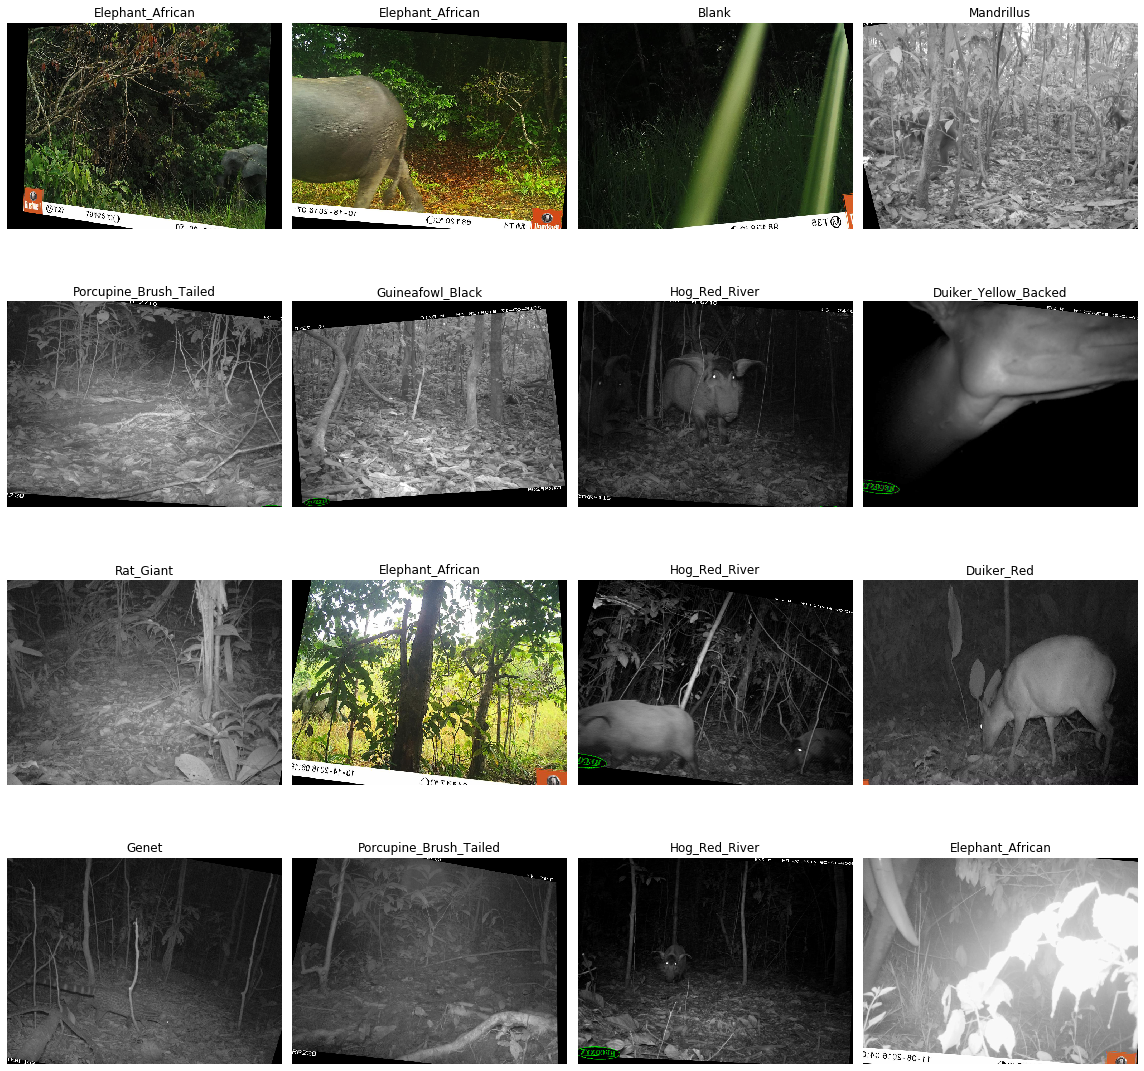

In [11]:
%%time
data.show_batch()

# Stage 3a

In [12]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage2a-5epochs-384_512-rescaled");

In [13]:
learn.freeze()

In [14]:
%%time
run_find_lr(learn, "stage3a-5epochs-576_768-rescaled")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/opt/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



CPU times: user 19.1 s, sys: 8.22 s, total: 27.4 s
Wall time: 1min 49s


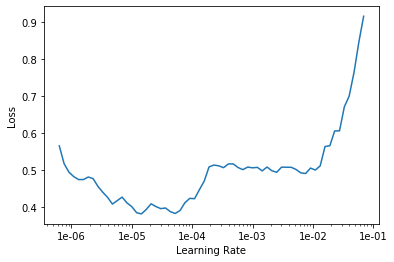

In [15]:
learn.recorder.plot()

In [17]:
initial_lr = 1e-3
# lr = 1e-6 * 2
# lr_end = initial_lr / 10
n_epochs =  5

In [ ]:
%%time
run_training(learn, "stage3a-5epochs-576_768-rescaled", initial_lr, n_epochs=n_epochs)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.recorder.plot_losses()

In [ ]:
fig = learn.recorder.plot_losses(return_fig=True)
fig.savefig("loss_plot-stage3a-5epochs-576_768-rescaled.png")

### Load model and investigate results

In [19]:
# learn = get_initial_learner(data)
# learn.load(PATH_TO_MODELS / "stage6-5epochs-384_512-rescaled");

In [20]:
# wandb.init(project="gabon")

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
conf_m = interp.confusion_matrix()
np.save("conf_m-stage3a-5epochs-576_768-rescaled.npy", conf_m)

In [ ]:
len(conf_m)

In [ ]:
correct_p = sum([conf_m[i,i] for i in range(len(conf_m))])
correct_p

In [ ]:
all_p = conf_m.sum().sum()
all_p

In [ ]:
print(f"accuracy is: {round(100 * correct_p / all_p,2)}%")

In [ ]:
new_order = np.load("new_order.npy")
plot_conf_matrix_reordered(conf_m, 
                           sorted(classes),
                           new_order,
                           save_as = "conf_m-new_order-stage3a-5epochs-576_768-rescaled.png",
                           for_model = "stage3a-5epochs-576_768-rescaled")

In [ ]:
preds = learn.get_preds(with_loss=True)
torch.save(preds, "preds-stage3a-5epochs-576_768-rescaled.pt")
preds

In [ ]:
images_list = data.valid_ds.items
np.save("images_list-stage3a-5epochs-576_768-rescaled.pt", images_list)

In [ ]:
images_list